In [26]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

import torch, os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

pd.set_option("display.max_columns", None)

np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

path_csv = "../data_horizons.csv"
path_pictures = "/Users/felix/Library/CloudStorage/Dropbox/data/BGR-Data-Bodenhorizonte/Profilbilder/"
path_images = "../images"
path_masks = "../masks"

df = pd.read_csv(path_csv, sep=';').dropna(subset=['Bodenart'])
image_dataset = os.listdir(path_pictures)
img_files = pd.DataFrame(image_dataset, columns=['image_path'])
img_files['Point'] = img_files['image_path'].str.split("_")\
                            .map(lambda x: x[1]).astype(float)
img_files
df = pd.merge(df, img_files, how='inner', on='Point')
df
df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,image_path
0,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SH_0002_Z_1.jpg
1,2.0,2.0,28.0,54.0,I; E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SH_0002_Z_1.jpg
2,2.0,3.0,54.0,68.0,II; Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SH_0002_Z_1.jpg
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SH_0002_Z_1.jpg
4,2.0,5.0,96.0,201.0,III; ilCv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SH_0002_Z_1.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15058,6211.0,3.0,27.0,50.0,I; Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NI_6211_Z_1.jpg
15059,6211.0,4.0,50.0,70.0,I; Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NI_6211_Z_1.jpg
15060,6211.0,5.0,70.0,100.0,I; Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NI_6211_Z_1.jpg
15061,6211.0,6.0,100.0,130.0,I; Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NI_6211_Z_1.jpg


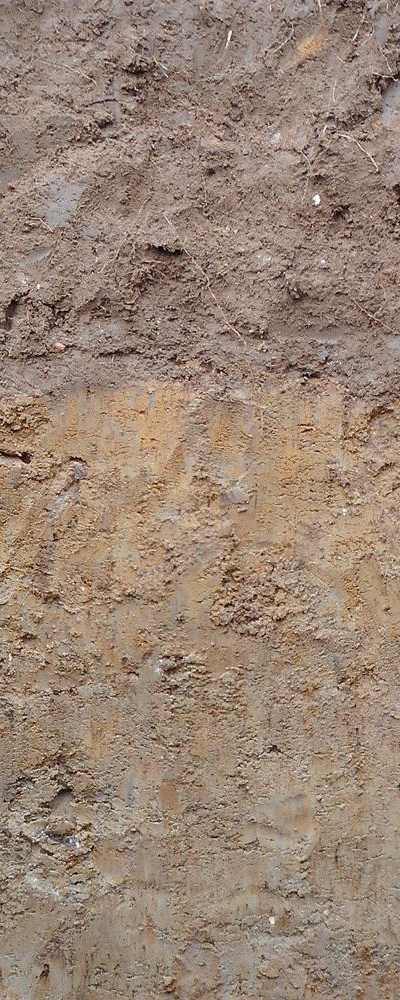

In [25]:
# Lade das Bild
image = Image.open(os.path.join(path_pictures,df['file'][600]))

x_len = 200
y_len = 500

# Definiere den Bereich, der ausgeschnitten werden soll (left, upper, right, lower)
# Beispiel: Ein Ausschnitt von (50, 50) bis (200, 200)
# left = 50
# upper = 50
# right = 200
# lower = 200
# crop_area = (left, upper, right, lower)

center_x, center_y = int(image.size[0] / 2), int(image.size[1] / 2)

left = center_x - x_len
right = center_x + x_len
upper = center_y - y_len
lower = center_y + y_len
crop_area = (left, upper, right, lower)

# Schneide den Bereich aus
cropped_image = image.crop(crop_area)

# Zeige den ausgeschnittenen Bereich
cropped_image

In [ ]:
# Custom Dataset class für Bilder, tabellarische Daten und Labels
class ImageTabularDataset(Dataset):
    def __init__(self, 
                 dataframe, 
                 transform=None, 
                 image_path=None, 
                 label=None,
                 feature_columns=None
                ):
        """
        dataframe: Pandas DataFrame mit Bildpfaden, tabellarischen Daten und Labels
        transform: Bildtransformationen
        """
        self.dataframe = dataframe
        self.transform = transform
        self.image_path = image_path
        self.label = label
        self.feature_columns = feature_columns

    def __len__(self):
        # Länge des Datasets (Anzahl der Zeilen im DataFrame)
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Extrahiere den Bildpfad aus dem DataFrame
        image_path = self.dataframe.iloc[idx][self.image_path]
        
        # Lade das Bild
        image = Image.open(image_path)
        
        # Wende Bildtransformationen an, falls vorhanden
        if self.transform:
            image = self.transform(image)
        
        # Extrahiere die tabellarischen Daten (numerische Features) aus dem DataFrame
        tabular_features = torch.tensor(self.dataframe.iloc[idx][self.feature_columns].values, dtype=torch.float32)
        
        # Extrahiere das Label
        label = torch.tensor(self.dataframe.iloc[idx][self.label], dtype=torch.long)  # Für Klassifikation (long)
        
        return image, tabular_features, label

# Beispiel DataFrame mit Bildpfaden, tabellarischen Daten und Labels
data = {
    'image_path': ["path_to_image1.png", "path_to_image2.png", "path_to_image3.png"],
    'age': [25, 30, 45],      # Tabellarische Daten: Alter
    'weight': [70.5, 80.2, 60.0],  # Tabellarische Daten: Gewicht
    'height': [175, 180, 165],     # Tabellarische Daten: Größe
    'label': [0, 1, 1]         # Labels (z.B. für binäre Klassifikation)
}

# Definiere die Transformationspipeline für die Bilder
transform = transforms.Compose([
    CenterCropTransform(150, 150),  # Verwende den zentrierten Ausschnitt
    transforms.RandomHorizontalFlip(p=0.5),  # Zufällige horizontale Spiegelung
    transforms.RandomRotation(degrees=15),  # Zufällige Rotation
    transforms.ToTensor(),  # Konvertiere das Bild in ein Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisierung
])

# Erstelle das Dataset mit DataFrame, Bildern und tabellarischen Daten
dataset = ImageTabularDataset(dataframe=df, 
                              transform=transform,
                              image_path='img_path',
                              label='Bodenart',
                              feature_columns=[]
                             )

# Erstelle den DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Schleife durch den DataLoader (Training oder Evaluierung)
for batch in dataloader:
    images, tabular_features, labels = batch
    print("Bilder-Shape:", images.shape)  # Shape der Bildtensoren
    print("Tabellarische Daten:", tabular_features)  # Tabellarische Daten pro Bild
    print("Labels:", labels)  # Labels für jedes Bild

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoFeatureExtractor

# Definiere das Modell mit DINOv2 Backbone von Hugging Face
class ImageTabularModelWithDINOv2(nn.Module):
    def __init__(self, dino_model_name, num_tabular_features, num_classes):
        super(ImageTabularModelWithDINOv2, self).__init__()
        
        # Lade das vortrainierte DINOv2-Modell von Hugging Face
        self.dino_model = AutoModel.from_pretrained(dino_model_name)
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(dino_model_name)
        
        # Definiere ein MLP für die tabellarischen Daten
        self.fc_tabular = nn.Sequential(
            nn.Linear(num_tabular_features, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Kombinierte Fully Connected Layers
        self.fc_combined = nn.Sequential(
            nn.Linear(768 + 16, 64),  # 768 ist die Ausgabegröße von DINOv2, 16 ist die Größe des MLP
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, image, tabular_features):
        # Extrahiere die Bildfeatures mit DINOv2 Backbone
        image_features = self.dino_model(pixel_values=image).last_hidden_state[:, 0, :]
        
        # Verarbeite die tabellarischen Daten mit dem MLP
        tabular_features_processed = self.fc_tabular(tabular_features)
        
        # Kombiniere Bild- und Tabellarische Features
        combined_features = torch.cat((image_features, tabular_features_processed), dim=1)
        
        # Endgültige Vorhersage
        output = self.fc_combined(combined_features)
        return output

# Beispiel zur Initialisierung des Modells
dino_model_name = "facebook/dino-v2-base"  # Du kannst auch andere DINOv2-Modelle verwenden
num_tabular_features = 3  # Anzahl der Features in deinen tabellarischen Daten
num_classes = 2  # Anzahl der Klassen für Klassifikation (z.B. binäre Klassifikation)

model = ImageTabularModelWithDINOv2(dino_model_name=dino_model_name, num_tabular_features=num_tabular_features, num_classes=num_classes)


In [ ]:
# Beispiel für die Bildvorverarbeitung mit dem DINOv2 Feature Extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(dino_model_name)

# Lade ein Beispielbild
image = Image.open("path_to_image.png")

# Vorverarbeitung des Bildes
inputs = feature_extractor(images=image, return_tensors="pt")

# Beispiel für tabellarische Daten
tabular_data = torch.tensor([[25.0, 70.5, 175.0]])  # z.B. Alter, Gewicht, Größe

# Wende das Modell an
model.eval()  # Setze das Modell in den Evaluierungsmodus
with torch.no_grad():
    outputs = model(image=inputs['pixel_values'], tabular_features=tabular_data)
    print(outputs)

# Beispiel: Definiere einen Optimizer und eine Loss-Funktion
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Trainingsschleife
model.train()
for epoch in range(10):
    optimizer.zero_grad()
    outputs = model(image=inputs['pixel_values'], tabular_features=tabular_data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item()}")

In [ ]:
from transformers import AutoImageProcessor, AutoModel

# ChatGPT Input:

```can you write me some python code to finetune a dinov2 checkpoint from hugging face on a computer vision classification task?
```
# ChatGPT Output:

Sure! Here’s a step-by-step guide and Python code for fine-tuning a DINOv2 model (from Hugging Face) for a computer vision classification task using PyTorch and the Hugging Face Transformers library.

## Steps to follow:


* Install the necessary libraries.
* Prepare the dataset for image classification.
* Load a pre-trained DINOv2 model from Hugging Face.
* Prepare the model for fine-tuning.
* Train the model on the dataset.
* Evaluate the performance.

Let’s go through the steps with Python code.

### Step 1: Install Required Libraries
First, ensure that you have the necessary libraries installed. You can install them using pip:

``` pip install transformers datasets torch torchvision evaluate```

### Step 2: Load Dataset

* Step 1: Set Up the DataFrame
Assume that your pandas DataFrame has two columns:

image_path: This contains the full path (or relative path) to each image file.

label: This contains the corresponding label for each image.

* Step 2: Custom Dataset Class
Now, we’ll write a custom PyTorch Dataset that reads from the DataFrame. The Dataset will:

Load the image from the given file path.
Apply transformations (e.g., resize, normalize).
Return the image along with its corresponding label.

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

###paths
path_csv = "../data_horizons.csv"
path_pictures = "/Users/felix/Library/CloudStorage/Dropbox/data/BGR-Data-Bodenhorizonte/Profilbilder/"
path_images = "../images"
path_masks = "../masks"


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# Definiere die Größe des rechteckigen Ausschnitts
crop_width = 200
crop_height = 400

# Definiere die Custom-Transformation für das Zuschneiden des Bildes
class CenterCropTransform:
    def __init__(self, crop_width, crop_height):
        self.crop_width = crop_width
        self.crop_height = crop_height

    def __call__(self, img):
        # Bildgröße ermitteln
        width, height = img.size
        
        # Berechne die Koordinaten für den zentrierten Ausschnitt
        left = (width - self.crop_width) // 2
        upper = (height - self.crop_height) // 2
        right = left + self.crop_width
        lower = upper + self.crop_height
        
        # Zuschnitt des Bildes
        return img.crop((left, upper, right, lower))

# Define the image transforms (resize, normalize, etc.)
transform = transforms.Compose([
    CenterCropTransform(crop_width, crop_height),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet statistics
])


# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): A pandas DataFrame with 'image_path' and 'label' columns.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples"""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Retrieves the image and label by index"""
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the image path and label from the DataFrame
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

        # Open the image file
        image = Image.open(img_path).convert("RGB")  # Convert image to RGB if it isn't already

        # Apply the optional transforms (like resize and normalization)
        if self.transform:
            image = self.transform(image)

        return image, label

# Instantiate the dataset
dataset = ImageDataset(df, transform=transform)

# Example: Get the first image and label from the dataset
img, label = dataset[0]
print(f"Image size: {img.size()}, Label: {label}")


### Step 3: DataLoader for Batching
Once we have the Dataset, we can use DataLoader to create batches of images and labels.

In [ ]:
from torch.utils.data import DataLoader

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate through the dataloader (example)
for batch_idx, (images, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx}:")
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    # Perform your training loop here


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Definiere die Größe des rechteckigen Ausschnitts
crop_width = 200
crop_height = 400

# Definiere die Custom-Transformation für das Zuschneiden des Bildes
class CenterCropTransform:
    def __init__(self, crop_width, crop_height):
        self.crop_width = crop_width
        self.crop_height = crop_height

    def __call__(self, img):
        # Bildgröße ermitteln
        width, height = img.size
        
        # Berechne die Koordinaten für den zentrierten Ausschnitt
        left = (width - self.crop_width) // 2
        upper = (height - self.crop_height) // 2
        right = left + self.crop_width
        lower = upper + self.crop_height
        
        # Zuschnitt des Bildes
        return img.crop((left, upper, right, lower))

# Define the image transforms (resize, normalize, etc.)
transform = transforms.Compose([
    CenterCropTransform(crop_width, crop_height),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet statistics
])

from transformers import AutoModelForImageClassification

# Load pre-trained DINOv2 model
model_name = "facebook/dinov2-vitb14"
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,  # Use the number of classes from your custom dataset
)

In [ ]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./dinov2-cifar10",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=1000,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none",  # Set to "wandb" or other service if tracking experiments
)

# Initialize the Trainer with the model, data, and training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
)

# Train the model
trainer.train()

In [ ]:
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()
print(f"Test Accuracy: {eval_results['eval_accuracy']}")

## legacy code

In [ ]:
from PIL import Image
import os
import numpy as np
import cv2
import pandas as pd

###parameters to adapt to the database
nbr_horizons = 15207
nbr_profile = 3101
i_h, i_w = 1500,1500  ##wanted high and width of the pictures and masks

###paths
path_csv = "data_horizons.csv"
path_pictures = "/Users/felix/Library/CloudStorage/Dropbox/data/BGR-Data-Bodenhorizonte/Profilbilder/"
path_images = "images"
path_masks = "masks"


###importation of Excel data
data = pd.read_csv(path_csv, sep=';')
numero = data["PointID"]
lettre = data["Bundesland"]
symboles = data["Horizontsymbol"]
hauteur_inf = data["Untergrenze"]
depthmax = data["max_depth"]
prof_hor = data["Point"]

### extract the main symbol from horizons names

symboles_simples = []
for k in range(nbr_horizons):
    symb = ""
    horizon = symboles[k]
    horizon = str(horizon)
    for car in horizon:
        if car in "AGSBCHMOP":
            symb = car
    if symb == "":
        symboles_simples += "0"
    else:
        symboles_simples += str(symb)


#### creation list of profiles
profile = []
for k in range(nbr_profile):
    if numero[k] < 10:
        profile += [str(str(lettre[k]) + "_000" + str(numero[k]))]
    elif numero[k] < 100:
        profile += [str(str(lettre[k]) + "_00" + str(numero[k]))]
    elif numero[k] < 1000:
        profile += [str(str(lettre[k]) + "_0" + str(numero[k]))]
    else:
        profile += [str(str(lettre[k]) + "_" + str(numero[k]))]



###creation of a list with the real depth of the bottom of the A-horizon

depth_reelle = []
k = 0
for i in range(nbr_profile):
    d = 0
    profil = int(numero[i])
    while prof_hor[k] == profil:
        if symboles_simples[k] == "A" and symboles_simples[k+1] != "A":
            d = hauteur_inf[k]
        k += 1
    if d == 0:
        depth_reelle += [str(profile[i] + "= 00")]
    elif d < 10:
        depth_reelle += [str(profile[i] + "= 0" + str(int(d)))]
    else:
        depth_reelle += [str(profile[i] + "= " + str(int(d)))]

depth_reelle.sort() #sorted by alphabetic order to ease the correlation between the 2 lists

hauteur_image = []
for elt in depth_reelle:
    hauteur_image += [int(elt[-3:])] #get only the depth without the profile name


###list of the depths in the resized pictures
depths = []
for k in range(nbr_profile):
    depth = ((hauteur_image[k] * i_h)/depthmax[k])
    depths.append(depth)


####list images
image_dataset = os.listdir(path_pictures)
images = []
# for profile in image_dataset:
#     path = os.path.join(path_pictures, profile)
#     img = Image.open(path).convert('RGB')
#     images.append(img)


###resize images and convert into array
# y = np.zeros((nbr_profile, i_h, i_w, 1), dtype=np.int32)
# X = np.zeros((nbr_profile, i_h, i_w,3), dtype=np.float32)

# for i in range(nbr_profile) :
#     single_img = images[i]

#     single_img = single_img.resize((i_h, i_w))
#     single_img = np.reshape(single_img, (i_h, i_w, 3))

#     X[i] = single_img


# ### create masks (that has the same dimensions of the image where each pixel is valued at 0 except for the A-horizon where pixel value = 1)

# for k in range (nbr_profile):
#     mask = np.zeros((i_h, i_w, 1), dtype=np.int32)
#     lim = depths[k]

#     if lim == 0:  #if depth =0 : no A-horizon in the profile
#         y[k] = mask
#     else:
#         cv2.rectangle(mask, (0, 0), (i_w, int(lim)), 1, -1)    # assimilate horizon to a rectangle
#         y[k] = mask

# ###save mask and images as png
# i = 1
# j = 1

# for img in X:
#     cv2.imwrite(path_images + "image" + str(i) + ".png", img)
#     i += 1

# for img in y:
#     cv2.imwrite(path_masks + "mask" + str(j) + ".png", img)
#     j += 1
